In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

repo_link = "https://raw.githubusercontent.com/berwynwong/econ4488/master/"
year_list = [1970, 1980, 1991, 2000]
ipums_list = []

for i, year in enumerate(year_list):
    ipums_raw = pd.read_csv(repo_link+"ipums{}.csv".format(year))
    var_dict = pd.read_csv(repo_link+"var_dict", index_col=0).to_dict() # renaming some commonly used variables
    ipums_list.append(ipums_raw.rename(columns=var_dict['newvar']))
    print("{} is done!".format(year))

C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


1970 is done!
1980 is done!
1991 is done!
2000 is done!


### We only consider Peninsular Malaysia male citizens who are wage workers

In [2]:
for i, df in enumerate(ipums_list):
    df = df[df.sex != 2] # Female
    df = df[df.geo1 !=458012] # Sabah, Labuan Federal Territory
    df = df[df.geo2 !=458013] # Sarawak
    df = df[df.empstat == 1] # Not employed
    df = df[df.age >=15]
    df = df[df.claswk !=3] # Unpaid
    ipums_list[i] = df

df_list = []

for i, df in enumerate(ipums_list):
    df = df[df.occ != 000]
    df = df[df.occ != 999]
    df = df[df.own != 0]
    df = df[df.birstate != 15] # Labuan
    df = df[df.marst !=0]
    df = df[df.ethmy != 99] # NIU (1991:14411, 2000:23399)
    df = df[df.empstat != 0] # NIU (54601, 48289, 89729, 99921)
    df = df[df.indgen != 000] # NIU (118484, 118426, 225137, 272021)
    df = df[df.claswk != 0] # NIU (120986, 118426, 210914, 271975)
    df_list.append(df)
    print("Shape is " + str(df.shape))
    print(df['YEAR'][0])

Shape is (31433, 36)
1970
Shape is (39378, 36)
1980
Shape is (68662, 36)
1991
Shape is (89270, 33)
2000


In [3]:
occ_missing = {1970: {998: np.NaN, 999: np.NaN},
               1980: {997: np.NaN, 998: np.NaN},
               1991: {995: np.NaN, 998: np.NaN},
               2000: {998: np.NaN, 999: np.NaN}}

missing_dict = {'age': {999: np.NaN},
                'birctry': {69900: np.NaN, 99999: np.NaN},
                'birstate': {99: np.NaN},
                'claswk': {9: np.NaN},
                'edat': {9: np.NaN},
                'edumy': {999: np.NaN},
                'empstat': {9: np.NaN},
                'ethmy': {98: np.NaN},
                'indgen': {999: np.NaN},
                'marst': {0: np.NaN, 9: np.NaN},
                'nat': {9: np.NaN},
                'own': {9: np.NaN},
                'relg': {9: np.NaN},
                'sex': {9: np.NaN},
                'urb': {9: np.NaN}}

In [4]:
for i, df in enumerate(df_list):
    df_year = df['YEAR'][0]
    for var in list(missing_dict):
        df = df.replace(missing_dict)
    df['occ'] = df['occ'].replace(occ_missing[df_year])
    df_list[i] = df

In [5]:
def df_recode(df):
    for precode, newcode in zip(['ethmy','edumy'],['race', 'edu']):
        code_dict = pd.read_csv(repo_link+newcode, index_col=0).to_dict()
        # I created dictionaries that classify Malaysian races and education in a way that makes sense given the context.
        # Categorised races into Malay, Chinese, Indian, non-Malay indigenous, Other
        # Categorised education into less than primary, primary, lower secondary, upper secondary, tertiary
        # See github repository for more details
        df[newcode] = df[precode].map(code_dict[precode])
    # I also used dictionaries for assigning ISEI scores to each occupational code
    df_year = df['YEAR'][0]
    isei_dict = pd.read_csv(repo_link+'isei'+str(df_year), index_col=0).to_dict()
    df['isei'] = df['occ'].map(isei_dict['occ'])
    return df

In [6]:
%%time
for i, df in enumerate(df_list):
    df_list[i] = df_recode(df)

Wall time: 3.2 s


In [7]:
for i, df in enumerate(df_list):
    for col in ['urb', 'geo1', 'geo2', 'own', 'nat', 'birctry',
                'birstate', 'relg', 'marst', 'empstat', 'indgen', 'claswk', 'race']:
        df[col] = df[col].astype('category')
        df_list[i]=df
        
for i, df in enumerate(df_list):
    df['edu'] = df['edu'].astype('category', ordered=True)
    df_list[i]=df

In [8]:
df_dict = {1970:df_list[0],
      1980:df_list[1],
      1991:df_list[2],
      2000:df_list[3]}

## Regression modelling

In [9]:
reg_form0 = "race"
reg_form1 = "race + edu + age + np.power(age, 2)"
reg_form2 = "race + edu + age + np.power(age, 2) + indgen + own + marst"
reg_form3 = "edu + age + np.power(age, 2) + indgen + own + marst + urb + claswk + geo2 + birstate"
reg_form4 = "race + edu + age + np.power(age, 2) + indgen + own + marst + urb + claswk + geo2 + birstate + race*edu"
reg_form5 = "race + edu + age + np.power(age, 2) + indgen + own + marst + urb + claswk + geo2 + birstate + race*edu + race*indgen+race*urb"

In [51]:
class Oaxaca(object):
        
    def __init__(self, df, races=[0,1], 
                 varlist=['edu', 'indgen', 'own', 'marst', 'urb', 'claswk', 'geo2', 'birstate', 'age'], 
                 reg=reg_form3):
        self.races = races
        self.varlist = varlist
        self.reg = reg_form3
        self.df = df
    
    def df_race(self, j=0):
        return self.df[self.df.race == j]
        
    def models(self, df_i):
        reg_line = 'isei ~'+self.reg
        x = smf.ols(reg_line, df_i).fit(cov_type='HC0')
        return x
    
    def df_boot(self,j):
        rfit, rres = self.models(self.df_race(j)).fittedvalues, self.models(self.df_race(j)).resid
        data = pd.DataFrame(data=np.transpose([np.log(np.square((rres.values))), rfit.values, np.square(rfit.values)]),
                            columns=['epsilon','fitted','fitted2'])
        x = smf.ols('epsilon ~ fitted + fitted2', data=data).fit(cov_type='HC0')
        pick =np.random.choice(a=x.resid, size=len(x.resid), replace=True)
#         array1 = np.array((np.ones(len(pick)), rfit, np.square(rfit).T, pick))
#         array2 = np.concatenate((x.params.values,[1]))
        le_star = x.fittedvalues + pick
        e_star = np.sign(rres.values) * np.exp(0.5*le_star)
        isei_boot = rfit + e_star
        df_boot = self.df_race(j).copy()
        df_boot['isei']=isei_boot
        return df_boot

#     def df_boot(self, j):
#         df_boot = self.df_race(j).sample(n=len(self.df_race(j)), replace=True)
#         return df_boot
    
    def char(self, j=0):
        char = [1]
        for v in self.varlist:
            if v == 'age':
                var_list = [self.df_race(j).age.mean(), np.square(self.df_race(j).age.mean())]
                char += var_list
            else:
                var_list = self.df_race(j)[v].value_counts(sort=False, normalize=True).tolist()
                char += var_list[1:]
        char = pd.Series(char, index=self.models(self.df_race(j)).params.index).values
        return char
    
    def betas(self, d='classic0', boot=False):
        if boot==True:
            df1,df2=self.df_boot(self.races[0]),self.df_boot(self.races[1])
        else:
            df1,df2=self.df_race(self.races[0]),self.df_race(self.races[1])
        df_full = pd.concat([df1, df2])
        bs0, bs1 = self.models(df1).params.values, self.models(df2).params.values
        if d=='ransom':
            b_param = smf.ols('isei~race+'+self.reg, df_full).fit().params.values
            b_c = np.concatenate([np.array(b_param[0]), b_param[4:]])
        elif d=='neumark':
            b_c = smf.ols('isei~'+self.reg, df_full).fit().params.values
        else:
            tau_dict = {'classic0':0, 'classic1':1, 'reimers':0.5, 
                        'cotton':self.df.race.value_counts(normalize=True).to_dict()[0]}
            tau = tau_dict[d]
            b_c = tau*bs0 + (1-tau)*bs1
        return bs0, bs1, b_c
    
    def decomp(self, d='classic0', boot=False):
        b0, b1, bc = self.betas(d, boot)
        j,k = self.races[0], self.races[1]
        R = b1@self.char(k) - b0@self.char(j)
        E = bc@(self.char(k) - self.char(j))
        D_former = self.char(k).T@(b1-bc)
        D_latter = self.char(j).T@(bc-b0)
        U = D_former + D_latter
        return R,E,D_former, D_latter, U
    
    def results(self, N, d='classic0'):
        dist_array = np.empty((N,5))
        total = N
        status='Bootstrapping'
        for i in range(N):
            dist_array[i]=self.decomp(d, boot=True)
            bar_len = 60
            filled_len = int(round(bar_len * i / float(total)))
            percents = round(100.0 * i / float(total), 1)
            bar = '=' * filled_len + '-' * (bar_len - filled_len)

            sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
            sys.stdout.flush()
        data = np.array([self.decomp(d), dist_array.T.mean(axis=1), np.median(dist_array.T, axis=1), dist_array.T.std(axis=1)])
        columns=['Actual', 'Boot. Mean', 'Boot.Median', 'Boot.Std']
        idx = ['Raw', 'Explained', 'Discrim. to former','Discrim. to latter', 'Total unexplained']
        results_df = pd.DataFrame(data.T, columns=columns, index=idx)
        results_df.name = '{}_{}_{}'.format(int(self.df.YEAR.mean()), str(self.races), d)
        return results_df, dist_array

In [77]:
%%time
b=Oaxaca(df_dict[1980]).results(1000, 'neumark')

Wall time: 54min 40s=========================================] 99.9% ...Bootstrapping


In [78]:
b[0].name

'1980_[0, 1]_neumark'

In [79]:
print(b[0])

                      Actual  Boot. Mean  Boot.Median  Boot.Std
Raw                 3.616982    2.397336     2.384705  0.564299
Explained           2.818183    2.490806     2.482196  0.179055
Discrim. to former  0.457748   -0.095219    -0.111108  0.325212
Discrim. to latter  0.341051    0.001748    -0.005537  0.215820
Total unexplained   0.798799   -0.093471    -0.112691  0.533779


In [83]:
ar=b[1].T[3]

In [84]:
import seaborn as sn

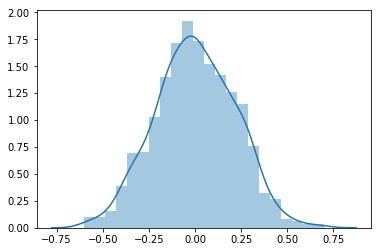

In [85]:
sn.distplot(ar)
plt.show()

In [70]:
R = ar.norm.interval(0.05,loc=mean,scale=std)

AttributeError: 'numpy.ndarray' object has no attribute 'norm'